# Deep Learning based Pipeline with Multichannel Inputs for Multi-class Patent Classification

This notebook describes a deep learning pipeline for automatic patent classification with multichannel inputs.  A neural network model is trained with multichannel inputs namely embeddings of different segments of patent texts, and sparse linear
input of different metadata. <br> <br>
<img src="arch_0000.png" height="600" width="700">

<br>
In this notebook the classification task is a multi-class classification. The basic outline is:  <br>  <br>

- load the patent dataset  <br>
- apply preprocessing tasks  <br>
- apply Tokenization process  <br>
- Load a pretrained word embeddings model  <br>
- prepare the embedding matrix for patent texts   <br>
- concatenated deep layers <br>
- train a deep neural network on the data  <br>
- Fit the model and show the results  <br>


#  Loading patent dataset
We established the training, and test datasets that are domain-specific datasets and related to the information technology domain.
The total number of extracted records in the datasets is about 430,000  patents filed between 1978 and 2016. Each patent document contains a  patent number, issued date, patent type, and list of citations, classification codes, a list of inventors, a list of assignees, title, abstract, technical field, background,  summary of invention, and independent claim. <br>
The data det is availabe in https://www.kaggle.com/darshmso/it-patent-dataset 
    

In [1]:
import pandas as pd

df = pd.read_csv("../datasets/allITPatTextWith_Metadata.csv",  encoding = "ISO-8859-1", error_bad_lines=False)
df.columns =['ID','TI','AB','TECHF','BACKG','SUMM','CLMS','ICM','AY','IPC','REF','PA','INV']

df.dropna(subset=['ICM'], inplace=True)


df.fillna(value='', inplace=True)

df.head()

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
0,EP2000017943-0,"Recognition code, particularly for a disk-shap...","A recognition code, particularly for a disk-li...",[1] The present invention relates to a recogni...,"[2] It is known that identification labels, ad...",[5] The aim of the present invention is to ove...,,G06K0019-06,2000,"[G06K0019-06, G06K0007-10]",,[Video System Italia S.r.l.],[Tassello Stefano]
1,EP2003016733-0,Optical pickup apparatus for recording/reprodu...,An optical pickup apparatus for reproducing in...,[1] The present invention relates to an optica...,"BACKGROUND OF THE INVENTION [2] Recently, as...",SUMMARY OF THE INVENTION[11] An object of the ...,['An optical pickup apparatus for recording an...,G11B0007-135,2000,"[G11B0007-135, G11B0007-125]",,[Konica Minolta Opto Inc.],"[Arai Norikazu, Kojima Toshiyuki, Kiriki To..."
2,EP2011009984-0,"Large capacity data sales mediation system, se...","An animation data sales mediation method, an a...",[1] The present invention relates to large cap...,BACKGROUND OF THE INVENTION Description of t...,SUMMARY OF THE INVENTION[20] The present inven...,['A large capacity data sales mediation system...,G07F0017-16,2001,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",[NEC Corporation],[Maeda Koji]
3,PCT1997010546-0,BRIDGE FOR A CLIENT-SERVER ENVIRONMENT,A software bridge (300) is introduced between ...,1 BRIDGE FOR A CLIENT-SERVER ENVIRONMENT Fiel...,Background of the Invention Overview of Object...,45 Disclosure of the Invention Accordingly the...,['1. A bridge (300) for use between a client (...,G06F009-46,1996,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,"[INTERNATIONAL BUSINESS MACHINES CORPORATION, ...",[COLYER ADRIAN MARK]
4,PCT1998021641-0,PROCESSOR HAVING SECTIONS OPERATING AT DIFFERE...,A processor (250) including a first execution ...,PROCESSOR HAVING SECTIONS OPERATING AT DIFFERE...,Background of the Prior Art Fig. 1 illustrates...,SUMMARY OF THE INVENTION The invention provide...,,G06F001-32,1997,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,,"[SAGER DAVID J, FLETCHER THOMAS D, HINTON GLEN..."


Text(0.5, 0, 'YEAR')

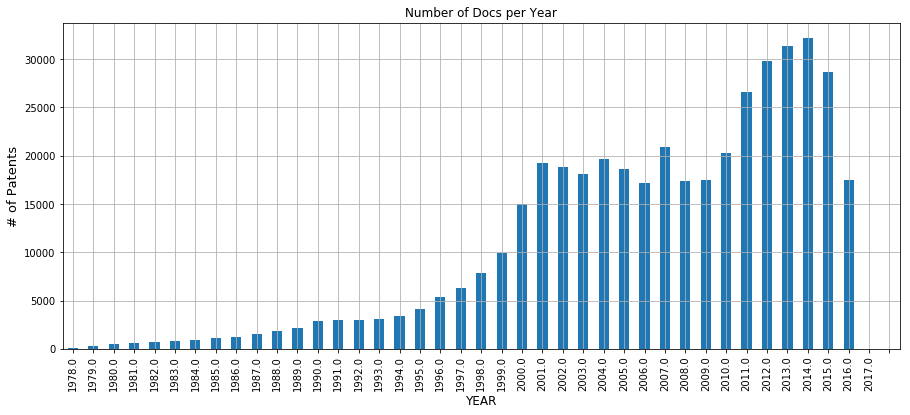

In [8]:
import matplotlib.pyplot as plt

df_AY = df.groupby(['AY'])
df_AY = df_AY.size().reset_index(name='Docs')


df_AY.plot(x='AY', y='Docs', kind='bar', legend=False, grid=True, figsize=(15, 6))
plt.title("Number of Docs per Year")
plt.ylabel('# of Patents', fontsize=13)
plt.xlabel('YEAR', fontsize=12)

# Applying preprocessing tasks on metadat of patent
Converting the metatadata such as inventors and assignees of each patent into a python list, then apply preprocessing task on each element in the list in order to remove undesired tokens.


In [2]:
%%time
#preprocess of list fields
#convert all IPCs in df into one list
def toList(s):
    """
    this method is to convert the list of IPCs in each row from a string to a python List
    """
    s  = s.translate ({ord(c): " " for c in "[]"})
    ss= []
    for cls in s.strip().split(','):
        ss.append(cls.strip())
    return ss

#apply toList method on all rows in the DF
df['PA'] = df['PA'].map(lambda pa :   toList(pa))
df['INV'] = df['INV'].map(lambda inv :   toList(inv))

df.head()  

CPU times: user 2.46 s, sys: 70.6 ms, total: 2.53 s
Wall time: 2.53 s


In [3]:
%%time

def metadataPreprocessing(input):
    newInput=' '
    for item in input:
        item = item.translate ({ord(c): " " for c in "!@#$%^&*()'[]{};:,./<>?\|`~°=\"+"})
        itms=' '
        for itm in item.split():
            itms= itms +' '+itm.strip()
        newInput = newInput + ' '+ itms.strip().replace(' ','_')
    return newInput.strip()

df['PA'] = df['PA'].map(lambda pa :   metadataPreprocessing(pa))
df['INV'] = df['INV'].map(lambda inv :   metadataPreprocessing(inv))

df.head()

CPU times: user 5.31 s, sys: 24.3 ms, total: 5.33 s
Wall time: 5.34 s


#  Applying preprocessing tasks on texts of patent
A simple preprocessing tasks such as tokenization, stopword removal, lemmatization, and converting letters into lower case are performed on each text section of each patent document.

In [4]:
#preprocessing 
standardStopwordFile = "sources/stopwords/stopwords-all.txt"

#loading terms from a file to a set
def get_terms_from_file(filePath):
    terms = set(line.strip() for line in open(filePath))
    return terms

#remove undiserd terms
def remove_terms(termSet, phrase):
    newPhrase = ""
    for term in phrase.split():
        if term.strip() not in termSet and len(term.strip())>2:
            newPhrase = newPhrase + " " + term.strip()



def clean_texts(doc):
    #Remove punctuation from texts
    doc = doc.translate ({ord(c): ' ' for c in "0123456789!@#$%^&*()'/[]{};:,./<>?\|`~°=\"+"})
    # split into tokens by white space
    tokens = doc.lower().strip().split()
    
    # filter out stop words
    stop_words = get_terms_from_file(standardStopwordFile)
    #generalStopwords = get_terms_from_file(generalWordsFile)

    
    tokens = [w.strip('-')  for w in tokens if  w not in stop_words ]
    # filter out short and long  tokens
    output = [word for word in tokens if len(word.strip()) > 2 and len(word) < 30 ]
    output = " ".join(output)
    #apply stemming
    #output = stem_text(output)
    return output



In [5]:
%%time
apply simple preprocessing on text
df['TI'] = df['TI'].map(lambda line : clean_texts(line))
df['AB'] = df['AB'].map(lambda line : clean_texts(line))
df['TECHF'] = df['TECHF'].map(lambda line : clean_texts(line))
df['BACKG'] = df['BACKG'].map(lambda line : clean_texts(line))
df['SUMM'] = df['SUMM'].map(lambda line : clean_texts(line))
df['CLMS'] = df['CLMS'].map(lambda line : clean_texts(line))


df.head()

CPU times: user 309 µs, sys: 76 µs, total: 385 µs
Wall time: 378 µs


,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K,2000.0,"[G06K0019-06, G06K0007-10]",,Video_System_Italia_S_r_l,Tassello_Stefano
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B,2000.0,"[G11B0007-135, G11B0007-125]",,Konica_Minolta_Opto_Inc,Arai_Norikazu_Kojima_Toshiyuki_Kiriki_Toshihik...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F,2001.0,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",NEC_Corporation,Maeda_Koji
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F,1996.0,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,INTERNATIONAL_BUSINESS_MACHINES_CORPORATION_CO...,COLYER_ADRIAN_MARK
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F,1997.0,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,,SAGER_DAVID_J_FLETCHER_THOMAS_D_HINTON_GLENN_J...


#  Applying preprocessing tasks for patent labels (main IPC codes)
The main IPC codes is considered to be the labels for the patent documents. we only consider the subclass level of the IPC code. 
Each label/class has at least more than 500 documents.

In [6]:
#process the ICM codes and #related-patents
df['ICM'] = df['ICM'].map(lambda icmCode : icmCode[:4])  

df_ICMs = df.groupby(['ICM'])
df_ICMs = df_ICMs.size().reset_index(name='Docs')

print(len(df_ICMs.ICM.unique()))
#filter out the rows with #docs less than N documents
df_ICMOut =  df_ICMs[df_ICMs['Docs'] >= 500]

#filter out rows of the original dataframe df accordding to df_ICMOut
ICMList = df_ICMOut['ICM'].tolist()
df = df[df.ICM.isin(ICMList)]

icmCount = df_ICMs.count().tolist()[0]

print( 'number of remaining documents in the dataset is: ',len(df))

print('Number of unique labels is: ', len(df.ICM.unique()))

42
number of remaining documents in the dataset is:  403726
Number of unique labels is:  42


# Randomly reorder a dataset by rows

In [7]:
from sklearn.utils import shuffle

df = shuffle(df)

df.head()

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPC,REF,PA,INV
62459,PCT2012055768-0,controlling rotary speed,controlling rotary speed pulse-width modulated...,concerns drehzahlregeÃ£ÂÃ¢Â¬ lung pulse-far-m...,speed regulation,describe improved speed regulation pulse-far-m...,,G06F,2011.0,"[G06F0001-20, H05K0007-20]",,,BUSCH_Peter
87947,PCT2011077221-0,electric power supply,electric power supply common power supply stor...,buildings power supply distribute electric pow...,power supply,defined building areas laid power network buil...,,H02J,2010.0,"[H02J0003-38, H02J0003-46, H02J0007-35, G06Q00...",,,TAKEHARA_Kiyotaka_NAKAKITA_Kenji
18014,EP2016068104-0,controlling tasks performed computing,controlling tasks includes receiving ordering ...,controlling tasks performed computing,techniques controlling tasks performed computi...,defined independent directed features dependen...,performing tasks storing memory instructions p...,G06F,2014.0,"[G06F0009-44, G06F0009-48]",,AB_Initio_Technology_LLC,STANFILL_Craig
84133,PCT2002013564-0,simplifying exchange sim card subscribers mobi...,simplifying exchange sim card subscribers mobi...,simplified sim map participants mobile net con...,portable radio products portable radio service...,consists suggesting simplified sim map partici...,procedures simplified sim map participants mob...,H04Q,2001.0,"[H04Q007-38, H04W0008-26]",,DETEMOBIL_DEUTSCHE_TELEKOM_MOBILNET_GMBH,REEMTSMA_Jan-Hinnerk
131689,EP2009025035-0,conversion services applications based applica...,converting page-based based configured configu...,transformation applications services network,continually devices today two-way devices mobi...,,enabling computing interact generic schema def...,G06F,2005.0,"[G06F0017-30, G06F0009-44]",[WO2004059957A],RESEARCH_IN_MOTION_LIMITED,Shenfield_Michael


# split the dataset into train and test datasets

In [8]:
# lets take n% data as training and remaining m% for test.
train_size = int(len(df) * .8)

train_TI = df['TI'][:train_size]
train_AB = df['AB'][:train_size]
train_TECHF = df['TECHF'][:train_size]
train_BACKG = df['BACKG'][:train_size]
train_SUMM = df['SUMM'][:train_size]
train_CLMS = df['CLMS'][:train_size]
train_ICM= df['ICM'][:train_size]
train_ID= df['ID'][:train_size]

test_TI = df['TI'][train_size:]
test_AB = df['AB'][train_size:]
test_TECHF = df['TECHF'][train_size:]
test_BACKG = df['BACKG'][train_size:]
test_SUMM = df['SUMM'][train_size:]
test_CLMS = df['CLMS'][train_size:]
test_ICM = df['ICM'][train_size:]
test_ID = df['ID'][train_size:]


#metadata
train_pa_series = df['PA'][:train_size]
test_pa_series = df['PA'][train_size:]

train_inv_series = df['INV'][:train_size]
test_inv_series = df['INV'][train_size:]


print(train_AB.shape)
print(test_AB.shape)

#free up some memory space
#df.iloc[0:0]

(322980,)
(80746,)


#  Applying tokenization process 
For texts of each segment, a Keras tokenization process is used for breaking the text into individual words, and  set the sequence length of each segment according to the length of each.


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.preprocessing import LabelBinarizer


Using TensorFlow backend.


Applying Keras tokenization on Metadata of patent(Inventors, Assignees), and convert the related text into One-hot that encodes a text into a list of word indexes of size n.

In [10]:
#PA
pa_inv_vocab_size = 2000
pa_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
pa_tokenizer.fit_on_texts(train_pa_series)
train_pa_one_hot =pa_tokenizer.texts_to_matrix(train_pa_series)
test_pa_one_hot =pa_tokenizer.texts_to_matrix(test_pa_series)


#INV
inv_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
inv_tokenizer.fit_on_texts(train_inv_series)
train_inv_one_hot =inv_tokenizer.texts_to_matrix(train_inv_series)
test_inv_one_hot =inv_tokenizer.texts_to_matrix(test_inv_series)


print('Found %s words in PA' % len(pa_tokenizer.word_index))
print('Found %s words in INV' % len(inv_tokenizer.word_index))

Found 88383 words in PA
Found 253812 words in INV


<br>
-  Transform each text in Titles (train and test datasets) into a sequence of integers. <br>
-  set the sequence length.<br>
-  Pads sequences to the same length.<br>



In [11]:
%%time

#Title
TI_tokenizer = Tokenizer(num_words=10000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TI_tokenizer.fit_on_texts(train_TI)
encoded_train_TI = TI_tokenizer.texts_to_sequences(train_TI)
encoded_test_TI = TI_tokenizer.texts_to_sequences(test_TI)
#convert all sequences in a list into the same length
TI_train = pad_sequences(encoded_train_TI,  maxlen=20, padding='post')
TI_test = pad_sequences(encoded_test_TI,  maxlen=20, padding='post')


CPU times: user 9.92 s, sys: 51.7 ms, total: 9.97 s
Wall time: 9.98 s


<br>
Transform each text in Abstrcat (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [12]:
%%time
#Abstract
AB_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
AB_tokenizer.fit_on_texts(train_AB)
encoded_train_AB = AB_tokenizer.texts_to_sequences(train_AB)
encoded_test_AB = AB_tokenizer.texts_to_sequences(test_AB)
#convert all sequences in a list into the same length
AB_train = pad_sequences(encoded_train_AB,  maxlen=100, padding='post')
AB_test = pad_sequences(encoded_test_AB,  maxlen=100, padding='post')


CPU times: user 27.4 s, sys: 253 ms, total: 27.6 s
Wall time: 27.7 s


<br>
Transform each text in Technical Field (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [13]:
%%time
#TECHNICAL_FIELD
TECHF_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TECHF_tokenizer.fit_on_texts(train_TECHF)
encoded_train_TECHF = TECHF_tokenizer.texts_to_sequences(train_TECHF)
encoded_test_TECHF = TECHF_tokenizer.texts_to_sequences(test_TECHF)
#convert all sequences in a list into the same length
TECHF_train = pad_sequences(encoded_train_TECHF,  maxlen=30, padding='post')
TECHF_test = pad_sequences(encoded_test_TECHF,  maxlen=30, padding='post')


CPU times: user 17.7 s, sys: 175 ms, total: 17.9 s
Wall time: 17.9 s


<br>
Transform each text in Background (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [14]:
%%time
#BACKGROUND
BACKG_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
BACKG_tokenizer.fit_on_texts(train_BACKG)
encoded_train_BACKG = BACKG_tokenizer.texts_to_sequences(train_BACKG)
encoded_test_BACKG = BACKG_tokenizer.texts_to_sequences(test_BACKG)
#convert all sequences in a list into the same length
BACKG_train = pad_sequences(encoded_train_BACKG,  maxlen=100, padding='post')
BACKG_test = pad_sequences(encoded_test_BACKG,  maxlen=100, padding='post')


CPU times: user 1min 56s, sys: 1.09 s, total: 1min 57s
Wall time: 1min 58s


<br>
Transform each text in Summary (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [15]:
%%time
#SUMMARY
SUMM_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
SUMM_tokenizer.fit_on_texts(train_SUMM)
encoded_train_SUMM = SUMM_tokenizer.texts_to_sequences(train_SUMM)
encoded_test_SUMM = SUMM_tokenizer.texts_to_sequences(test_SUMM)
#convert all sequences in a list into the same length
SUMM_train = pad_sequences(encoded_train_SUMM,  maxlen=100, padding='post')
SUMM_test = pad_sequences(encoded_test_SUMM,  maxlen=100, padding='post')


CPU times: user 2min 37s, sys: 1.51 s, total: 2min 38s
Wall time: 2min 38s


<br>
Transform each text in Independent Claim (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [16]:
%%time
#CLAIMS
CLMS_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
CLMS_tokenizer.fit_on_texts(train_CLMS)
encoded_train_CLMS = CLMS_tokenizer.texts_to_sequences(train_CLMS)
encoded_test_CLMS = CLMS_tokenizer.texts_to_sequences(test_CLMS)
#convert all sequences in a list into the same length
CLMS_train = pad_sequences(encoded_train_CLMS,  maxlen=100, padding='post')
CLMS_test = pad_sequences(encoded_test_CLMS,  maxlen=100, padding='post')


CPU times: user 37.8 s, sys: 697 ms, total: 38.5 s
Wall time: 38.6 s


# Pre-processing Output Labels / Classes
 we  need to make sure our labels are represented in the numeric format accepted by neural network model.  We need to convert our labels to one hot vector. <br>

scikit-learn has a LabelBinarizer class which makes it easy to build these one-hot vectors.

In [17]:
%%time
# 
encoder = LabelBinarizer()
encoder.fit(train_ICM)
y_train = encoder.transform(train_ICM)
y_test = encoder.transform(test_ICM)

#get the unique number of labels in the training set
classesList = train_ICM.tolist()
classesList =set(classesList)
num_classes = len(classesList)

CPU times: user 2.54 s, sys: 66.8 ms, total: 2.6 s
Wall time: 2.6 s


#  load the whole embeddings model into memory and get matrix
We load a pre-trained word2vec word embedding model that was trained on five million patents (Titles and abstracts)<br>

The Embeddings model is availabel <a href=https://www.kaggle.com/darshmso/w2vec-patent-domain > here.</a>

In [18]:
import numpy as np

def load_embedding_model(filePath):
    embeddings_index = dict()
    f = open(filePath, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, vocab_size_embbs, dim_size):
    embeddings_matrix = np.zeros((vocab_size_embbs, dim_size))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector[0:dim_size]
    
    return embeddings_matrix


 Loading the whole embedding into memory and get matrix

In [19]:
%%time

embedding_index = load_embedding_model('../models/w2v/phrase/patWordPhrase2VecModel.txt')


CPU times: user 1min 28s, sys: 2.77 s, total: 1min 31s
Wall time: 1min 31s


<br>
Creating TITLE embeddings Matrix

In [20]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TI_tokenizer.word_index) + 1

TI_embeddings_matrix = create_embedding_matrix(TI_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              20)




CPU times: user 85 ms, sys: 56.9 ms, total: 142 ms
Wall time: 140 ms



Creating ABSTRACT embeddings Matrix

In [21]:
%%time

#vocab_size for embedding
vocab_size_embb = len(AB_tokenizer.word_index) + 1
AB_embeddings_matrix = create_embedding_matrix(AB_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)


CPU times: user 256 ms, sys: 126 ms, total: 382 ms
Wall time: 382 ms


Creating TECHNICAL_FIELD embeddings Matrix

In [22]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TECHF_tokenizer.word_index) + 1
TECHF_embeddings_matrix = create_embedding_matrix(TECHF_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              30)

CPU times: user 160 ms, sys: 42.9 ms, total: 203 ms
Wall time: 202 ms


Creating BACKGROUND embeddings Matrix

In [23]:
%%time

#vocab_size for embedding
vocab_size_embb = len(BACKG_tokenizer.word_index) + 1
BACKG_embeddings_matrix = create_embedding_matrix(BACKG_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 639 ms, sys: 225 ms, total: 864 ms
Wall time: 865 ms


Creating SUMMARY embeddings Matrix

In [24]:
%%time

#vocab_size for embedding
vocab_size_embb = len(SUMM_tokenizer.word_index) + 1
SUMM_embeddings_matrix = create_embedding_matrix(SUMM_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 586 ms, sys: 216 ms, total: 802 ms
Wall time: 803 ms


Creating INDEPENDENT CLAIMS embeddings Matrix

In [25]:
%%time

#vocab_size for embedding
vocab_size_embb = len(CLMS_tokenizer.word_index) + 1
CLMS_embeddings_matrix = create_embedding_matrix(CLMS_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 197 ms, sys: 62.9 ms, total: 259 ms
Wall time: 259 ms


# Creating a Deep Layer for each Input

In [26]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Embedding, BatchNormalization, ELU, Concatenate
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout


<br> Creating LSTM deep layer for Title Embeddings<br>

In [27]:
%%time
#TITLE 
sequence_len =20
dropout_pct =  0.3

TI_embedding_layer_input = Input(shape=(sequence_len,), name='TI_embed_input')
TI_embedding_layer = Embedding(input_dim=len(TI_tokenizer.word_index) + 1,
                        output_dim=20, # Dimension of the dense embedding
                        weights=[TI_embeddings_matrix],
                        input_length=20)(TI_embedding_layer_input)

lstm_size = 64
TI_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TI')(TI_embedding_layer)

TI_deep = Dense(300, activation=None)(TI_deep)
TI_deep = Dropout(dropout_pct)(TI_deep)
TI_deep = BatchNormalization()(TI_deep)
TI_deep = ELU()(TI_deep)


CPU times: user 4.72 s, sys: 9 s, total: 13.7 s
Wall time: 4.59 s


<br> Creating LSTM deep layer for Abstract Embeddings<br>


In [28]:
%%time
#Abstract 
sequence_len =100
dropout_pct =  0.3

AB_embedding_layer_input = Input(shape=(sequence_len,), name='AB_embed_input')
AB_embedding_layer = Embedding(input_dim=len(AB_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[AB_embeddings_matrix],
                        input_length=100)(AB_embedding_layer_input)

lstm_size = 64
AB_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_AB')(AB_embedding_layer)

AB_deep = Dense(300, activation=None)(AB_deep)
AB_deep = Dropout(dropout_pct)(AB_deep)
AB_deep = BatchNormalization()(AB_deep)
AB_deep = ELU()(AB_deep)


CPU times: user 3.3 s, sys: 6.57 s, total: 9.87 s
Wall time: 827 ms


<br> Creating LSTM deep layer for TECHNICAL-Field Embeddings<br>


In [29]:
%%time
#TECHNICAL-Field 
sequence_len =30
dropout_pct =  0.3

TECHF_embedding_layer_input = Input(shape=(sequence_len,), name='TECHF_embed_input')
TECHF_embedding_layer = Embedding(input_dim=len(TECHF_tokenizer.word_index) + 1,
                        output_dim=30, # Dimension of the dense embedding
                        weights=[TECHF_embeddings_matrix],
                        input_length=30)(TECHF_embedding_layer_input)

lstm_size = 64
TECHF_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TECHF')(TECHF_embedding_layer)

TECHF_deep = Dense(300, activation=None)(TECHF_deep)
TECHF_deep = Dropout(dropout_pct)(TECHF_deep)
TECHF_deep = BatchNormalization()(TECHF_deep)
TECHF_deep = ELU()(TECHF_deep)

CPU times: user 3.52 s, sys: 6.23 s, total: 9.75 s
Wall time: 693 ms


<br> Creating LSTM deep layer for BACKGROUND Embeddings<br>

In [30]:
%%time
#BACKGROUND 
sequence_len =100
dropout_pct =  0.3

BACKG_embedding_layer_input = Input(shape=(sequence_len,), name='BACKG_embed_input')
BACKG_embedding_layer = Embedding(input_dim=len(BACKG_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[BACKG_embeddings_matrix],
                        input_length=100)(BACKG_embedding_layer_input)

lstm_size = 64
BACKG_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_BACK')(BACKG_embedding_layer)

BACKG_deep = Dense(300, activation=None)(BACKG_deep)
BACKG_deep = Dropout(dropout_pct)(BACKG_deep)
BACKG_deep = BatchNormalization()(BACKG_deep)
BACKG_deep = ELU()(BACKG_deep)

CPU times: user 3.72 s, sys: 7.52 s, total: 11.2 s
Wall time: 2.16 s


<br> Creating LSTM deep layer for Summary Embeddings<br>

In [31]:
%%time
#SUMMARY
sequence_len =100
dropout_pct =  0.3

SUMM_embedding_layer_input = Input(shape=(sequence_len,), name='SUMM_embed_input')
SUMM_embedding_layer = Embedding(input_dim=len(SUMM_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[SUMM_embeddings_matrix],
                        input_length=100)(SUMM_embedding_layer_input)

lstm_size = 64
SUMM_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_SUMM')(SUMM_embedding_layer)

SUMM_deep = Dense(300, activation=None)(SUMM_deep)
SUMM_deep = Dropout(dropout_pct)(SUMM_deep)
SUMM_deep = BatchNormalization()(SUMM_deep)
SUMM_deep = ELU()(SUMM_deep)

CPU times: user 3.78 s, sys: 6.7 s, total: 10.5 s
Wall time: 1.44 s


<br> Creating LSTM deep layer for Independent Claim Embeddings<br>

In [32]:
%%time
#CLAIMS 
sequence_len =100
dropout_pct =  0.4


CLMS_embedding_layer_input = Input(shape=(sequence_len,), name='CLMS_embed_input')
CLMS_embedding_layer = Embedding(input_dim=len(CLMS_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[CLMS_embeddings_matrix],
                        input_length=100)(CLMS_embedding_layer_input)

lstm_size = 64
CLMS_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_CLMS')(CLMS_embedding_layer)

CLMS_deep = Dense(300, activation=None)(CLMS_deep)
CLMS_deep = Dropout(dropout_pct)(CLMS_deep)
CLMS_deep = BatchNormalization()(CLMS_deep)
CLMS_deep = ELU()(CLMS_deep)

CPU times: user 3.55 s, sys: 6.46 s, total: 10 s
Wall time: 981 ms


<br> Creating LSTM deep layers for one-hot vectors of Inventors and Assignees<br>

In [33]:
dropout_pct =  0.3
pa_input = Input(shape=(train_pa_one_hot.shape[1],), name='pa_input') 
pas = Dense(32,input_dim=train_pa_one_hot.shape[1], activation=None)(pa_input) 
pas = Dropout(dropout_pct)(pas)
pas = BatchNormalization()(pas)
pas = ELU()(pas)

#inv
inv_input = Input(shape=(train_inv_one_hot.shape[1],), name='inv_input') 
invs = Dense(32,input_dim=train_inv_one_hot.shape[1], activation=None)(pa_input) 
invs = Dropout(dropout_pct)(invs)
invs = BatchNormalization()(invs)

print('pa_input and inv_input layers are finished')

pa_input and inv_input layers are finished


# Train Model
The following cells specify the neural network architecture and hyperparameters. <br>

The model is generally composed of:<br>

- contacting sequential word embeddings ofpatent text segments into a fully-connected layer
-  categorical_accuracy is used for calculatinges the mean accuracy rate across all predictions for multiclass classification problems <br>
- Compile the  the Network. <br>


In [34]:
import keras_metrics as km
#contacting 
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep] 
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model = Model(inputs=[TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     ],
              outputs=output, name='model')
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
SUMM_embed

Train / Fit the Network

In [35]:
%%time
batch_size= 500 
num_epochs = 20

history = model.fit(x={'TI_embed_input': TI_train,
                       'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train
             
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test
            },
           y_test))


Train on 322980 samples, validate on 80746 samples
Epoch 1/20
322980/322980 [==============================] - 461s 1ms/step - loss: 1.7969 - acc: 0.5258 - precision: 0.4037 - recall: 0.0159 - val_loss: 1.4179 - val_acc: 0.5861 - val_precision: 0.4080 - val_recall: 0.2372
Epoch 2/20
322980/322980 [==============================] - 450s 1ms/step - loss: 1.4392 - acc: 0.5846 - precision: 0.4834 - recall: 0.0867 - val_loss: 1.3088 - val_acc: 0.6032 - val_precision: 0.4631 - val_recall: 0.3163
Epoch 3/20
322980/322980 [==============================] - 442s 1ms/step - loss: 1.3511 - acc: 0.6010 - precision: 0.5133 - recall: 0.1648 - val_loss: 1.2841 - val_acc: 0.6077 - val_precision: 0.4656 - val_recall: 0.4984
Epoch 4/20
322980/322980 [==============================] - 436s 1ms/step - loss: 1.2965 - acc: 0.6114 - precision: 0.5304 - recall: 0.1961 - val_loss: 1.2290 - val_acc: 0.6202 - val_precision: 0.4645 - val_recall: 0.5178
Epoch 5/20
322980/322980 [==============================] - 4

In [36]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

<br>Train the neural network on  multichannel inputs namely deep layers of patent text segments 
 and deep layers of patent metadata.<br>

In [37]:
import keras_metrics as km

#contacting two input models
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep, pas, invs] 
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model2 =Model(inputs=[ TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     pa_input,
                      inv_input],
              outputs=output, name='model')
model2.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
SUMM_embed

Fit the model/network

In [38]:
%%time
batch_size= 500 
num_epochs = 20


history2 = model2.fit(x={'TI_embed_input': TI_train,
                         'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train,
             'pa_input': train_pa_one_hot,
             'inv_input': train_inv_one_hot
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
           y_test))

Train on 322980 samples, validate on 80746 samples
Epoch 1/20
322980/322980 [==============================] - 477s 1ms/step - loss: 1.1486 - acc: 0.6703 - precision: 0.6459 - recall: 0.3769 - val_loss: 1.1171 - val_acc: 0.6656 - val_precision: 0.5228 - val_recall: 0.5860
Epoch 2/20
322980/322980 [==============================] - 458s 1ms/step - loss: 0.9977 - acc: 0.6915 - precision: 0.6642 - recall: 0.4410 - val_loss: 1.1003 - val_acc: 0.6631 - val_precision: 0.5672 - val_recall: 0.5465
Epoch 3/20
322980/322980 [==============================] - 456s 1ms/step - loss: 0.9683 - acc: 0.6973 - precision: 0.6755 - recall: 0.4547 - val_loss: 1.1008 - val_acc: 0.6602 - val_precision: 0.5137 - val_recall: 0.6256
Epoch 4/20
322980/322980 [==============================] - 457s 1ms/step - loss: 0.9485 - acc: 0.7034 - precision: 0.6799 - recall: 0.4739 - val_loss: 1.0926 - val_acc: 0.6635 - val_precision: 0.5520 - val_recall: 0.5597
Epoch 5/20
322980/322980 [==============================] - 4

<br>Train the neural network on  multichannel inputs namely deep layers of Title and Technical Field.<br>

In [39]:


#contacting two input models
model_inputs_to_concat = [TI_deep,  TECHF_deep] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(64, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model3 =Model(inputs=[ TI_embedding_layer_input,
                      TECHF_embedding_layer_input
                      ],
              outputs=output, name='model')
model3.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       860380      TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 30)       4292250     TECHF_embed_input[0][0]          
__________________________________________________________________________________________________
LSTM_TI (L

<br> Fit the model <br>

In [40]:
%%time
batch_size= 500 
num_epochs = 20


history3 = model3.fit(x={'TI_embed_input': TI_train,
             'TECHF_embed_input': TECHF_train
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test
            },
           y_test))

Train on 322980 samples, validate on 80746 samples
Epoch 1/20
322980/322980 [==============================] - 55s 169us/step - loss: 1.6390 - acc: 0.5718 - precision: 0.5691 - recall: 0.1416 - val_loss: 1.4379 - val_acc: 0.5923 - val_precision: 0.4446 - val_recall: 0.3953
Epoch 2/20
322980/322980 [==============================] - 48s 148us/step - loss: 1.4377 - acc: 0.5924 - precision: 0.5717 - recall: 0.1956 - val_loss: 1.4040 - val_acc: 0.5979 - val_precision: 0.4448 - val_recall: 0.3907
Epoch 3/20
322980/322980 [==============================] - 49s 151us/step - loss: 1.4060 - acc: 0.5983 - precision: 0.5748 - recall: 0.2081 - val_loss: 1.3956 - val_acc: 0.5963 - val_precision: 0.4803 - val_recall: 0.3690
Epoch 4/20
322980/322980 [==============================] - 50s 154us/step - loss: 1.3865 - acc: 0.6016 - precision: 0.5945 - recall: 0.2233 - val_loss: 1.3819 - val_acc: 0.6000 - val_precision: 0.4606 - val_recall: 0.3946
Epoch 5/20
322980/322980 [==============================]

<br>Train the neural network on  multichannel inputs namely deep layers of Title, abstrcat and Technical Field.<br>

In [41]:
import keras_metrics as km
#contacting two input models
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model4 = Model(inputs=[TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input
                     ],
              outputs=output, name='model')
model4.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       860380      TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_

<br>Fit the model <br>

In [42]:
%%time
batch_size= 500 
num_epochs = 20


history4 = model4.fit(x={'TI_embed_input': TI_train,
                         'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test
            },
           y_test))

Train on 322980 samples, validate on 80746 samples
Epoch 1/20
322980/322980 [==============================] - 154s 476us/step - loss: 1.2702 - acc: 0.6409 - precision: 0.6272 - recall: 0.2992 - val_loss: 1.2700 - val_acc: 0.6334 - val_precision: 0.4969 - val_recall: 0.4310
Epoch 2/20
322980/322980 [==============================] - 144s 444us/step - loss: 1.1308 - acc: 0.6586 - precision: 0.6388 - recall: 0.3405 - val_loss: 1.2481 - val_acc: 0.6326 - val_precision: 0.4970 - val_recall: 0.4550
Epoch 3/20
322980/322980 [==============================] - 144s 446us/step - loss: 1.1071 - acc: 0.6636 - precision: 0.6475 - recall: 0.3466 - val_loss: 1.2487 - val_acc: 0.6304 - val_precision: 0.4724 - val_recall: 0.4783
Epoch 4/20
322980/322980 [==============================] - 144s 445us/step - loss: 1.0942 - acc: 0.6660 - precision: 0.6503 - recall: 0.3613 - val_loss: 1.2582 - val_acc: 0.6254 - val_precision: 0.5224 - val_recall: 0.4240
Epoch 5/20
322980/322980 [===========================

<br>Train the neural network on  multichannel inputs namely deep layers of Title, Technical Field, Inventors, and Assignees.<br>

In [43]:

#contacting two input models
model_inputs_to_concat = [TI_deep, TECHF_deep,  pas, invs] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='softmax')(output)

model5 =Model(inputs=[ TI_embedding_layer_input,
                      TECHF_embedding_layer_input,
                     pa_input,
                      inv_input],
              outputs=output, name='model')
model5.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 20)       860380      TI_embed_input[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 30)       4292250     TECHF_embed_input[0][0]          
__________________________________________________________________________________________________
LSTM_TI (L

<br> Fit the mode. <br>

In [44]:
%%time
batch_size= 500 
num_epochs = 20


history5 = model5.fit(x={'TI_embed_input': TI_train,
             'TECHF_embed_input': TECHF_train,
             'pa_input': train_pa_one_hot,
             'inv_input': train_inv_one_hot
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'TECHF_embed_input': TECHF_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
           y_test))

Train on 322980 samples, validate on 80746 samples
Epoch 1/20
322980/322980 [==============================] - 64s 199us/step - loss: 1.3491 - acc: 0.6212 - precision: 0.6471 - recall: 0.3138 - val_loss: 1.3344 - val_acc: 0.6147 - val_precision: 0.5265 - val_recall: 0.4163
Epoch 2/20
322980/322980 [==============================] - 57s 175us/step - loss: 1.1993 - acc: 0.6403 - precision: 0.6491 - recall: 0.3595 - val_loss: 1.3275 - val_acc: 0.6149 - val_precision: 0.4900 - val_recall: 0.4760
Epoch 3/20
322980/322980 [==============================] - 57s 176us/step - loss: 1.1797 - acc: 0.6449 - precision: 0.6636 - recall: 0.3673 - val_loss: 1.3184 - val_acc: 0.6148 - val_precision: 0.4844 - val_recall: 0.4922
Epoch 4/20
322980/322980 [==============================] - 57s 176us/step - loss: 1.1670 - acc: 0.6459 - precision: 0.6683 - recall: 0.3721 - val_loss: 1.3128 - val_acc: 0.6121 - val_precision: 0.4762 - val_recall: 0.5109
Epoch 5/20
322980/322980 [==============================]